In [1]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.preprocessing import image
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

## Transfer Learning

In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
length, width = 100, 100
pretrained_model = InceptionV3(input_shape = (length,width,3),
                               include_top = False,
                               weights = None)
local_weights = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model.load_weights(local_weights)

In [3]:
for layer in pretrained_model.layers:
    layer.trainable = False

In [66]:
trainFile = 'Industrious/indoor' #'wework_imageType/indoors'
trainFile_ls = [i for i in os.listdir(trainFile) if i.find('jpg')!=-1]
trainList = []
for f in trainFile_ls: #os.listdir(trainFile)[:1000]:
    temp = image.load_img(os.path.join(trainFile, f),
                          target_size = (length, width))
    d = image.img_to_array(temp)
    d = np.expand_dims(d, axis = 0)
    trainList.append(np.vstack(d))

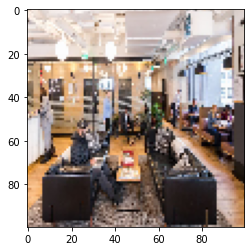

In [58]:
# import matplotlib.pyplot as plt
# %matplotlib inline  
# plt.imshow(image.load_img('wework_imageType/indoors/wework_0_1.jpg',target_size = (100,100)))
# plt.show()

In [67]:
pred = pretrained_model.predict(np.array(trainList))

In [68]:
pred.shape

(693, 1, 1, 2048)

In [69]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(2048, activation='relu'),
#    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(length * width * 3, activation = 'relu')
])
model2.compile(loss = 'mse', 
               optimizer = 'rmsprop',
               metrics = ['mse'])

y = np.array(trainList).reshape(len(trainList), -1)
history = model2.fit(pred, y, 
                     epochs = 10, 
                     batch_size = 250, 
                     validation_split = 0.2, 
                     verbose = 1)

Epoch 1/10
3/3 [==============================] - 3s 679ms/step - loss: 15444.2148 - mse: 15444.2148 - val_loss: 7140.1621 - val_mse: 7140.1621
Epoch 2/10
3/3 [==============================] - 2s 625ms/step - loss: 6971.2510 - mse: 6971.2510 - val_loss: 6107.9121 - val_mse: 6107.9121
Epoch 3/10
3/3 [==============================] - 2s 630ms/step - loss: 6237.8721 - mse: 6237.8721 - val_loss: 6030.4062 - val_mse: 6030.4062
Epoch 4/10
3/3 [==============================] - 2s 645ms/step - loss: 6097.2959 - mse: 6097.2959 - val_loss: 6164.6792 - val_mse: 6164.6792
Epoch 5/10
3/3 [==============================] - 2s 581ms/step - loss: 6097.8271 - mse: 6097.8271 - val_loss: 6025.0825 - val_mse: 6025.0825
Epoch 6/10
3/3 [==============================] - 2s 584ms/step - loss: 6067.6519 - mse: 6067.6519 - val_loss: 6110.6289 - val_mse: 6110.6289
Epoch 7/10
3/3 [==============================] - 2s 584ms/step - loss: 6083.6929 - mse: 6083.6929 - val_loss: 6204.6567 - val_mse: 6204.6567
Epoc

## Use Sample Pics to Cluster

In [23]:
# import PIL
# from pathlib import Path
# from PIL import UnidentifiedImageError

# path = Path("SamplePics").rglob("*.jpg")
# for img_p in path:
#     try:
#         img = PIL.Image.open(img_p)
#     except PIL.UnidentifiedImageError:
#             print(img_p)

In [8]:
testFile = 'SamplePics'
testFile_ls = [i for i in os.listdir(testFile) if i.find('jpg')!=-1]
# 'SamplePics'里含Mac系统自动创建的'.DS_Store'和'.ipynb_checkpoints'文件
testList = []
for f in testFile_ls:
    try:
        temp = image.load_img(os.path.join(testFile, f),
                              target_size = (length, width))
        d = image.img_to_array(temp)
        d = np.expand_dims(d, axis = 0)
        testList.append(np.vstack(d))
    except:
        print(f)

In [9]:
np.array(testList).shape

(50, 100, 100, 3)

In [70]:
pred_test = pretrained_model.predict(np.array(testList))
ypred = model2.predict(pred_test)
y = np.array(testList).reshape(len(testList),-1)
ydelta = y - ypred

In [42]:
ydelta.shape

(50, 30000)

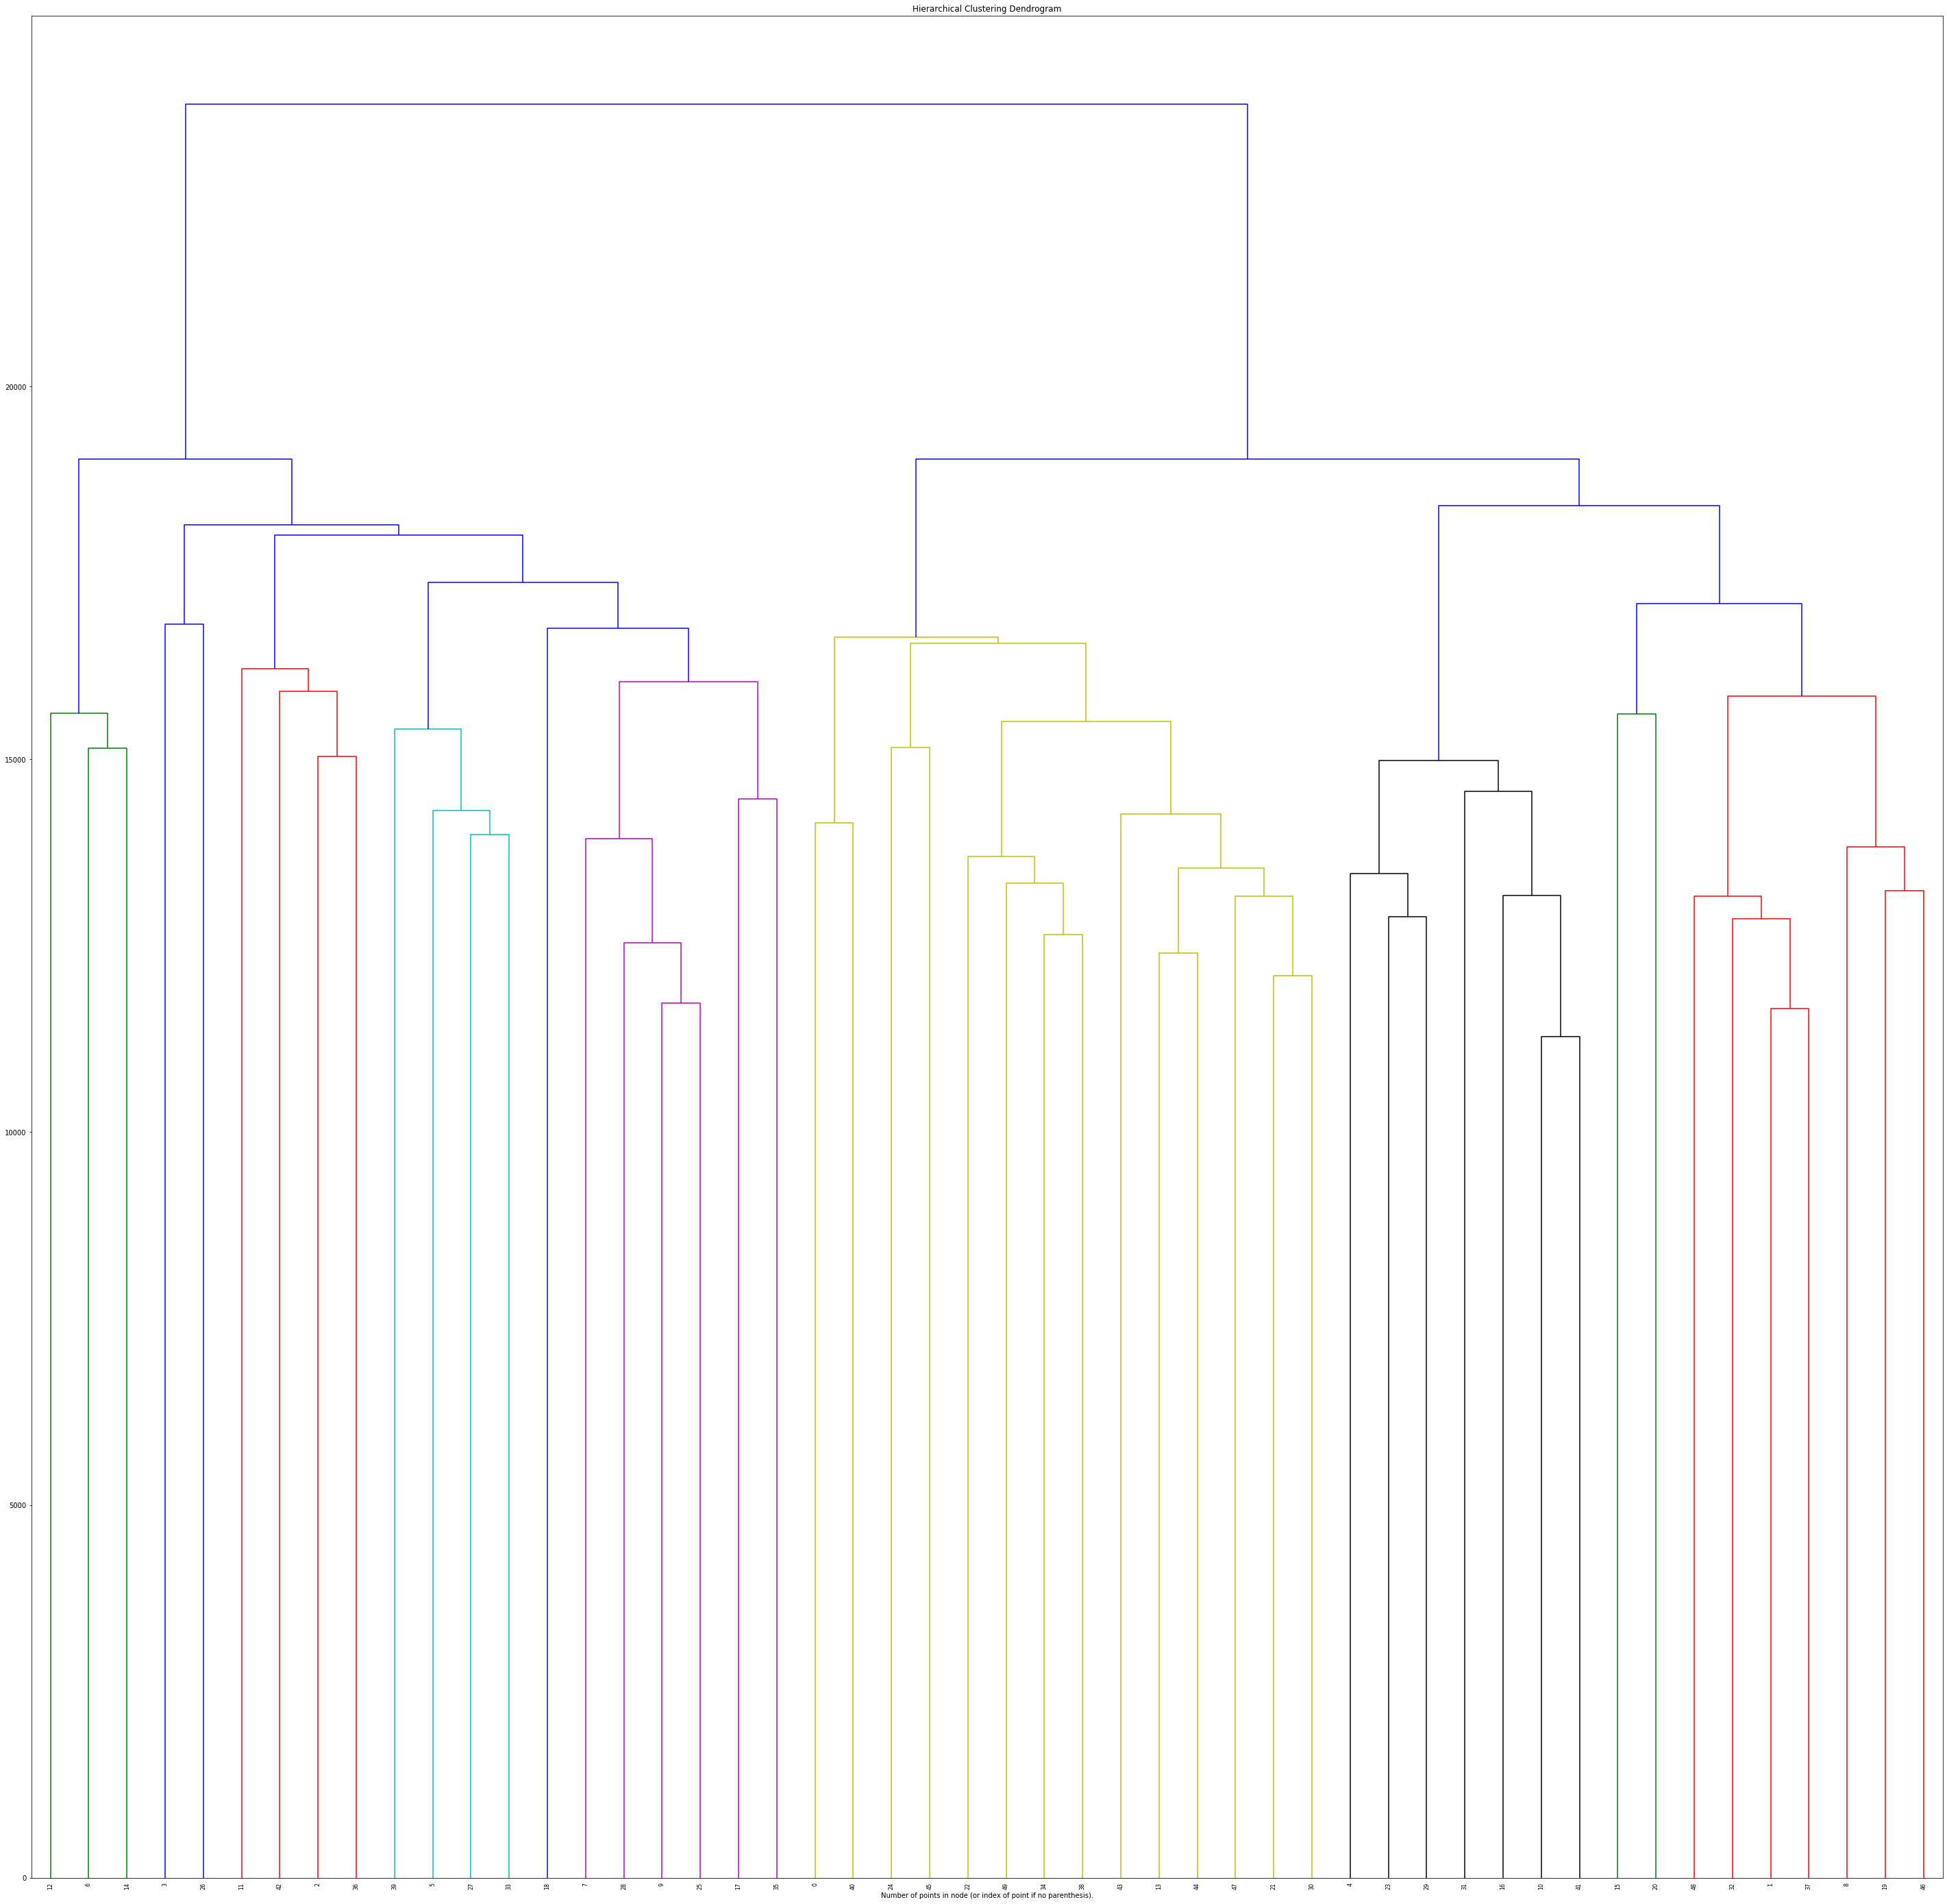

In [71]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    
    # Create linkage matrix and then plot the dendrogram

    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(ydelta)

plt.figure(figsize=(50,50))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=30)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [78]:
n_clusters = 4
acm = AgglomerativeClustering(n_clusters)
y_pred_acm = acm.fit_predict(ydelta)

In [79]:
y_pred_acm

array([2, 0, 1, 1, 0, 1, 3, 1, 0, 1, 0, 1, 3, 2, 3, 0, 0, 1, 1, 0, 0, 2,
       2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 0, 1, 2, 1, 1, 0, 2, 1, 2, 0, 1, 2,
       2, 2, 0, 2, 0, 2])

In [16]:
def cluster_center(y_pred_acm, ydelta, n_clusters):
    center = {}
    for i in range(n_clusters):
        ysum = np.zeros(ydelta[0].shape)
        ycount = 0
        for cluster, yd in zip(y_pred_acm, ydelta):
            if cluster == i:
                ysum = ysum + yd
                ycount +=1
        center[i] = ysum/ycount
    return center

In [80]:
centers = cluster_center(y_pred_acm, ydelta, n_clusters)

In [106]:
#centers

{0: array([ 43.53148324,  31.71906607,  13.23381587, ...,  11.13883536,
        134.78571429, -47.7947028 ]),
 1: array([ 31.95800061,  14.099425  ,  -9.77694787, ...,  36.65455839,
        170.61111111,   7.08365589]),
 2: array([  42.7521286 ,    7.26603699,  -19.75308736, ...,  -20.11916351,
          99.5       , -103.52601624]),
 3: array([ 52.793094  ,  37.22902934,  -0.60486031, ...,  58.1683108 ,
        167.08333333, -15.65968831]),
 4: array([nan, nan, nan, ..., nan, nan, nan])}

In [81]:
dist_from_center = []
for cluster, yd in zip(y_pred_acm, ydelta):
    dist_from_center.append(np.sqrt(np.sum(np.square(yd - centers[cluster]))))    

In [92]:
#import pandas as pd
cluster_result = pd.DataFrame({'cluster': y_pred_acm,
                               'distance': dist_from_center,
                               'file_name': testFile_ls,
                               'ydelta': list(ydelta)})

In [93]:
cluster_result.head()

,cluster,distance,file_name,ydelta
0,2,11092.012313,48.jpg,"[27.740784, 29.894218, 1.5441437, 76.6951, 182..."
1,0,9200.300800,49.jpg,"[-34.402542, 0.8467102, 2.5487518, -39.54921, ..."
2,1,10518.826313,8.jpg,"[-101.66797, -37.7614, -19.518234, -79.442825,..."
3,1,11929.513192,9.jpg,"[-5.5471344, 39.576614, 33.310898, 62.20018, 2..."
4,0,9374.337230,14.jpg,"[-69.74388, -44.810196, -53.125046, -96.08435,..."


In [94]:
new_center = cluster_result.sort_values(['cluster','distance']).groupby('cluster').head(1)
new_center

,cluster,distance,file_name,ydelta
37,0,8143.852442,43.jpg,"[6.423996, 32.036224, 16.777359, 37.821182, 17..."
9,1,7732.632188,16.jpg,"[38.26593, 77.07976, 57.571686, 73.26283, 253...."
30,2,8359.644567,30.jpg,"[31.864609, 52.882065, 43.98445, 49.61061, 215..."
6,3,8711.571354,29.jpg,"[-24.986588, -86.56537, -95.56082, -53.74649, ..."


In [98]:
new_center_dict = new_center.set_index('cluster').T.to_dict('list')
new_center_dict

{0: [8143.852441656495,
  '43.jpg',
  array([ 6.423996, 32.036224, 16.777359, ..., 87.45315 , 86.039856,
         91.580505], dtype=float32)],
 1: [7732.632187643724,
  '16.jpg',
  array([38.26593 , 77.07976 , 57.571686, ..., 35.686966, 34.97853 ,
         13.77652 ], dtype=float32)],
 2: [8359.644566672558,
  '30.jpg',
  array([31.864609, 52.882065, 43.98445 , ..., 73.24259 , 37.2977  ,
         11.637108], dtype=float32)],
 3: [8711.571354343661,
  '29.jpg',
  array([ -24.986588,  -86.56537 ,  -95.56082 , ..., -131.71284 ,
         -129.3314  , -116.35704 ], dtype=float32)]}

In [99]:
dist_from_center = []
for cluster, yd in zip(y_pred_acm, ydelta):
    dist_from_center.append(np.sqrt(np.sum(np.square(yd - new_center_dict[cluster][2]))))    

In [100]:
cluster_result = pd.DataFrame({'cluster': y_pred_acm,
                               'distance': dist_from_center,
                               'file_name': testFile_ls,
                               'ydelta': list(ydelta)})
cluster_result.sort_values(['cluster','distance']).groupby('cluster').head(3)

,cluster,distance,file_name,ydelta
37,0,0.000000,43.jpg,"[6.423996, 32.036224, 16.777359, 37.821182, 17..."
1,0,11661.250000,49.jpg,"[-34.402542, 0.8467102, 2.5487518, -39.54921, ..."
48,0,12063.378906,1.jpg,"[48.229813, 56.17743, 43.321, 101.79587, 246.0..."
9,1,0.000000,16.jpg,"[38.26593, 77.07976, 57.571686, 73.26283, 253...."
25,1,11733.768555,27.jpg,"[13.244247, 50.91252, 51.050262, 17.781754, 19..."
28,1,11765.741211,18.jpg,"[-25.51213, -0.09140015, 1.8719635, 5.489624, ..."
30,2,0.000000,30.jpg,"[31.864609, 52.882065, 43.98445, 49.61061, 215..."
21,2,12097.776367,22.jpg,"[-24.656387, 1.1593323, -2.3108368, -3.0030823..."
47,2,12188.909180,47.jpg,"[-88.01669, -48.70894, -62.26802, -41.52968, 1..."
6,3,0.000000,29.jpg,"[-24.986588, -86.56537, -95.56082, -53.74649, ..."


In [84]:
#import shutil
for cluster, file in zip(y_pred_acm, testFile_ls):
    if not os.path.exists('clusters1'):
        os.mkdir('clusters1')
    if not os.path.exists('clusters1/%d'%cluster):
        os.mkdir('clusters1/%d'%cluster)
    shutil.copy(os.path.join(testFile, file), "clusters1/%d/"%cluster+file)